In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

pysindy_path = r'C:\Users\phili\PycharmProjects\pysindy'

In [3]:
from test_data import add_noise,experiment_data

# Solution of KDV: $u(t,x)=\frac{c}{2}\cosh(\frac{\sqrt{c}}{2}(x-ct))^{-2}$
We have here that $u$ solves the one-way wave equation $u_t = -c u_x$ and the KDV equation $u_t= 6uu_x-u_{xxx}$.

In [4]:
experiment_name = 'algbraic_nonunique_kdv'
u,x,t,formula = experiment_data(n_samples=200,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

algbraic_nonunique_kdv
0.874882736527349/cosh(1.15728351889698*t - 0.661393504854466*x)**2


How does it look with noise?

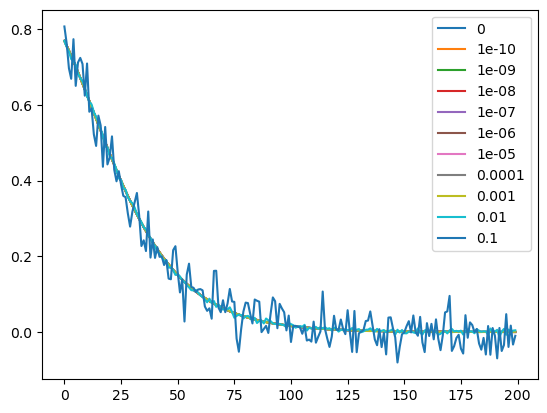

In [48]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
i=10
for target_noise in noise_levels:
    u_noise = add_noise(u,target_noise)
    plt.plot(u_noise[i],label=str(target_noise))
plt.legend()
#plt.savefig("noise_levels_func.png")
plt.show()

## Check now numerically that we have ambiguity problems

We already know $u$ is not an algebraic function, so we have to check the rank of the feature matrix constructed out of $u$, $u_x$, $u_{xx}$, $u_{xxx}$ and their monomials up to degree 3.

In [6]:
from numpy.linalg import matrix_rank, svd
from itertools import product

In [7]:
def monomials(features, order):
    multi_indices = []
    indices = np.arange(order + 1)
    number_features = features.shape[0]
    repeat_indices = [indices for i in range(number_features)]
    for i in product(*repeat_indices):
        if sum(i) <= order:
            multi_indices += [i]
    new_features = []
    for multi_index in multi_indices:
        new_feature = 1
        for i, j in enumerate(multi_index):
            new_feature *= features[i]**j
        new_features.append(new_feature.reshape(1,-1))
    return np.concatenate(new_features,axis=0)

In [35]:
def calc_distance_svs(u,polynomial_order,fd_orders=range(2,8)):
    distance_svs = []
    for fd_order in fd_orders:
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                             drop_endpoints=False)._differentiate(u, dx)
        uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0,
                                  drop_endpoints=False)._differentiate(u, dx)
        uxxx = ps.FiniteDifference(order=fd_order, d=3, axis=0,
                                   drop_endpoints=False)._differentiate(u, dx)
        uxxxx = ps.FiniteDifference(order=fd_order, d=4, axis=0,
                                    drop_endpoints=False)._differentiate(u, dx)
    
        u_flat, u_x_flat, u_xx_flat, u_xxx_flat = u.flatten(), ux.flatten(), uxx.flatten(), uxxx.flatten()
        base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1), u_xx_flat.reshape(len(u_flat),-1), u_xxx_flat.reshape(len(u_flat),-1)], axis=1).T 
        library = monomials(base_features, order=polynomial_order)
        svs = svd(library[1:], compute_uv=False)
        distance_svs.append(svs[-1])
    return distance_svs

## Singular value ratio plots
Interestingly, one can easily realize the pattern by looking at the ratio between the highest and lowest singular value. For the case that linear dependence exists, we see an exponential growth here with repect to an increasing order of the finite differences method.

### Polynomials of order 1
As $u$ and its derivatives are not linear dependent, we should not see an exponential decay here.

Noise level: 0
Distance SVS: [24.568561005946002, 24.57321447878964, 24.573837511773892, 24.573842582036068, 24.57384278215802, 24.57384278208023]
Noise level: 1e-10
Distance SVS: [24.568560260319142, 24.573213144408417, 24.573837770326517, 24.573850005052574, 24.573869611005943, 24.57391561901495]
Noise level: 1e-09
Distance SVS: [24.56859881508515, 24.573288703888494, 24.573980746797982, 24.574154137521266, 24.574593030175468, 24.576086896761655]
Noise level: 1e-08
Distance SVS: [24.56906385983615, 24.57513722748635, 24.578556010789224, 24.590477158761768, 24.632031078341726, 24.785521633729356]
Noise level: 1e-07
Distance SVS: [24.58255695527812, 24.684499168877192, 24.851314040278197, 25.705455758252594, 28.109719137516425, 32.09756181130279]
Noise level: 1e-06
Distance SVS: [26.089735698534398, 30.916274117994018, 33.516475329371964, 35.32310870430876, 35.77369123034425, 35.94593322217216]
Noise level: 1e-05
Distance SVS: [35.56767347934414, 36.12140044530496, 36.344885818487334, 

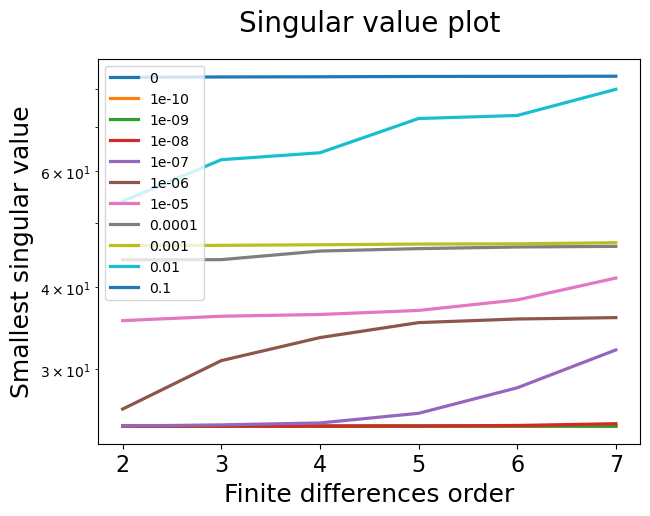

In [40]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
titlesize = 20
labelsize = titlesize - 2
tickssize = labelsize - 2
plt.figure(figsize=(7,5))
plt.title('Singular value plot', size=titlesize, y=1.05)
plt.xlabel('Finite differences order', size=labelsize)
plt.ylabel('Smallest singular value', size=labelsize)
#plt.ylim((10**(-3),10**2))
plt.xticks(fontsize=tickssize)
plt.yticks(fontsize=tickssize)
plt.yscale('log')

for target_noise in noise_levels:
    u_noise = add_noise(u,target_noise)
    distance_svs = calc_distance_svs(u_noise,polynomial_order=1)
    print(f"Noise level: {target_noise}")
    print(f"Distance SVS: {distance_svs}")
    plt.plot(range(2,8), distance_svs, linewidth=2.3,label=str(target_noise))
plt.legend()
plt.show()
 

### Polynomials of order 2
As $u$ and its derivatives are algebraically dependent with minimal polynom of degree 2, we expect an exponential decay here.

Noise level: 0
Distance SVS: [0.0004296725764896795, 2.5571632726223106e-05, 7.90263706023511e-07, 4.5952598390968126e-08, 2.7424731455298243e-09, 2.0488031455937862e-10]
Noise level: 1e-10
Distance SVS: [0.0004347734758220133, 4.7576196951598917e-05, 1.276580293474582e-05, 1.6151626973870965e-05, 2.2313586326207246e-05, 3.676572622302821e-05]
Noise level: 1e-09
Distance SVS: [0.0006027742873401157, 0.00010618856500766708, 0.00012191342223922325, 0.00015611140319738578, 0.00022194037170452234, 0.00036070902239829613]
Noise level: 1e-08
Distance SVS: [0.0013660594666771032, 0.0007784182942999477, 0.0012220637874963425, 0.0015845874884850195, 0.0022737451454497627, 0.003778706236109556]
Noise level: 1e-07
Distance SVS: [0.00845938147188075, 0.007715279603517072, 0.012177272984066768, 0.015690749403239133, 0.021933597830414382, 0.035342012315029786]
Noise level: 1e-06
Distance SVS: [0.08314355870725108, 0.07787358038744431, 0.11918486452271919, 0.15036173620690826, 0.2061525754764654, 0.3

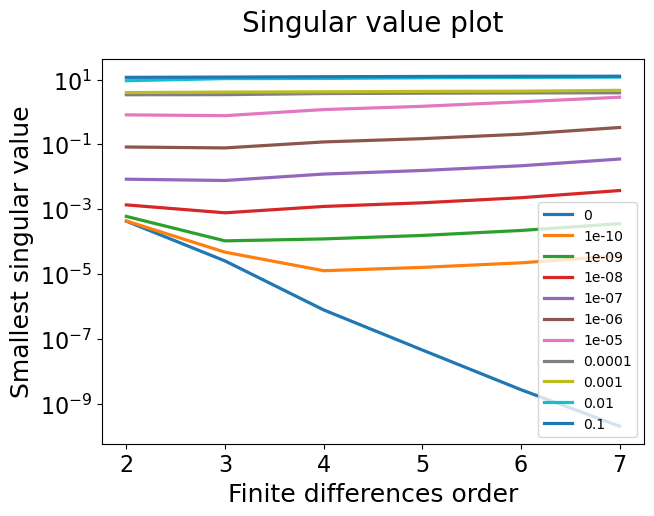

In [42]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]

plt.figure(figsize=(7,5))
plt.title('Singular value plot', size=titlesize, fontname="Times New Roman", y=1.05)
plt.xlabel('Finite differences order', size=labelsize, fontname="Times New Roman")
plt.ylabel('Smallest singular value', size=labelsize, fontname="Times New Roman")
plt.xticks(fontsize=tickssize)
plt.yticks(fontsize=tickssize)
plt.yscale('log')
for target_noise in noise_levels:
    u_noise = add_noise(u,target_noise)
    distance_svs = calc_distance_svs(u_noise,polynomial_order=2)
    print(f"Noise level: {target_noise}")
    print(f"Distance SVS: {distance_svs}")
    plt.plot(range(2,8), distance_svs, linewidth=2.3,label=str(target_noise))
plt.legend()
plt.show()